# Libraries

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob


# Paths

In [10]:
base_path = r"C:\Users\laura\OneDrive - Danmarks Tekniske Universitet\Dokumenter\AS DTU\FALL 2024 DTU\Perception for Autonomous Systems\Final project\34759_final_project_raw\34759_final_project_raw\calib"
path_cam2 = os.path.join(base_path, "image_02", "data")
path_cam3 = os.path.join(base_path, "image_03", "data")

# Get all image paths
cam2 = sorted(glob.glob(os.path.join(path_cam2, "*.png")))
cam3 = sorted(glob.glob(os.path.join(path_cam3, "*.png")))

# Individual calibration

In [11]:

# Arrays to store real-world points and image points
objpoints = []  # 3D points in real-world space
imgpoints1 = []  # 2D points in the image from camera 1
imgpoints2 = []  # 2D points in the image from camera 2

# Store detected corners to avoid duplicates
detected_corners1 = []
detected_corners2 = []

# Images to show all detections
all_corners_img1 = None
all_corners_img2 = None


# Boxes x, y, w, h
roi2 = [[130, 120, 180, 210], [370, 170, 110, 140], [460, 70, 170, 75], [510, 270, 90, 120], [490, 385, 180, 130], [680, 290, 90, 120], [790, 130, 130, 100], [800, 300, 100, 120], [1000, 60, 200, 100], [1100, 250, 100, 130], [1000, 380, 144, 70], [1240, 160, 75, 280], [1320, 180, 70, 170]]
roi3 = [[40, 120, 240, 230], [300, 170, 130, 150], [372, 83, 164, 77], [450, 260, 90, 120], [380, 335, 280, 190], [600, 290, 90, 120], [680, 80, 230, 160], [690, 250, 200, 180], [890, 10, 300, 160], [990, 240, 100, 120], [895, 365, 138, 72], [1136, 157, 58, 262], [1200, 160, 66, 180]]

gridsizes = [(7,11), (7,11), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,15), (5,7)]


for i, (fname1, fname2) in enumerate(zip(cam2[:1], cam3[:1])):
    
    # Read images
    img1_original = cv2.imread(fname1)
    img2_original = cv2.imread(fname2)
    h, w = img1_original.shape[:2]
    
    # Resize images to improve detection
    img1_resized = cv2.resize(img1_original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img2_resized = cv2.resize(img2_original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale
    gray1 = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

    # Enhance contrast and brightness
    alpha = 1.8  # Contrast control
    beta = 10    # Brightness control
    gray1 = cv2.convertScaleAbs(gray1, alpha=alpha, beta=beta)
    gray2 = cv2.convertScaleAbs(gray2, alpha=alpha, beta=beta)

    # Create base images for combined detection visualization
    if all_corners_img1 is None:
        all_corners_img1 = img1_original.copy()
        all_corners_img2 = img2_original.copy()

    for j, (box1, box2, size) in enumerate(zip(roi2, roi3, gridsizes)):
        
        # Prepare real-world 3D points
        objp = np.zeros((size[0] * size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1, 2)
        objp *= 10e-2  # Square size in meters (10 cm)

        # Create masks for ROIs
        mask1 = np.zeros_like(gray1)
        mask2 = np.zeros_like(gray2)
        mask1[box1[1]*2:box1[1]*2+box1[3]*2, box1[0]*2:box1[0]*2+box1[2]*2] = 255
        mask2[box2[1]*2:box2[1]*2+box2[3]*2, box2[0]*2:box2[0]*2+box2[2]*2] = 255

        gray1_masked = cv2.bitwise_and(gray1, mask1)
        gray2_masked = cv2.bitwise_and(gray2, mask2)

        # Detect chessboards
        ret1, corners1 = cv2.findChessboardCorners(gray1_masked, size)
        ret2, corners2 = cv2.findChessboardCorners(gray2_masked, size)



        if ret1 and ret2:
            # Refine corners
            corners1 = cv2.cornerSubPix(
                gray1_masked, corners1, (7, 7), (-1, -1),
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            )
            # corners1 = corners1[::-1]
            corners2 = cv2.cornerSubPix(
                gray2_masked, corners2, (7, 7), (-1, -1),
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            )
            # corners2 = corners2[::-1]

            # Scale corners back to original size
            corners1 /= 2
            corners2 /= 2

            # def enforce_consistent_order(corners1, corners2):
            #     # Check the orientation of the first row
            #     if np.linalg.norm(corners1[0] - corners1[-1]) < np.linalg.norm(corners2[0] - corners2[-1]):
            #         corners2 = corners2[::-1]  # Reverse corners2 if needed

            #     # Check the orientation of the first column
            #     if np.linalg.norm(corners1[0] - corners1[size[0] - 1]) < np.linalg.norm(corners2[0] - corners2[size[0] - 1]):
            #         corners2 = corners2.reshape(size[::-1])[::-1].reshape(-1, 1, 2)  # Flip vertically if needed

            #     return corners1, corners2
            
            # corners1, corners2 = enforce_consistent_order(corners1, corners2)
            def reverse_columns(corners, grid_size):
                # Reshape to rows x columns
                corners_grid = corners.reshape(grid_size[1], grid_size[0], 2)  # (cols, rows, 2)
                # Reverse columns
                corners_grid = corners_grid[:, ::-1, :]
                # Flatten back to the original shape
                return corners_grid.reshape(-1, 1, 2)

            print(f'J: {j}')
            if j in [4,10]:
                # print("Reversing columns")
                corners2 = corners2[::-1]
                # corners2 = reverse_columns(corners2, size)

            cv2.drawChessboardCorners(all_corners_img1, size, corners1, ret1)
            cv2.drawChessboardCorners(all_corners_img2, size, corners2, ret2)
            # plt.figure(figsize=(15, 7))
            # plt.subplot(2, 2, 1)
            # plt.title("All Chessboards Camera Left")
            # plt.imshow(cv2.cvtColor(all_corners_img1, cv2.COLOR_BGR2RGB))
            # plt.axis("off")

            # plt.subplot(2, 2, 2)
            # plt.title("All Chessboards Camera Right")
            # plt.imshow(cv2.cvtColor(all_corners_img2, cv2.COLOR_BGR2RGB))
            # plt.axis("off")

            # plt.subplot(2, 2, 3)
            # plt.title("Mask Left")
            # plt.imshow(gray1_masked)
            # plt.axis("off")

            # plt.subplot(2, 2, 4)
            # plt.title("Mask Right")
            # plt.imshow(gray2_masked)
            # plt.axis("off")
            # plt.show()

            imgpoints1.append(corners1)
            imgpoints2.append(corners2)
            objpoints.append(objp)

#Plot results

# imgpoints1 = np.vstack(imgpoints1).reshape(1, -1, 2)
# imgpoints2 = np.vstack(imgpoints2).reshape(1, -1, 2)

for img_path2, img_path3 in zip(cam2, cam3):
    img2 = cv2.imread(img_path2)  # Camera 2 image
    img3 = cv2.imread(img_path3)  # Camera 3 image

    # Get the image size (used for stereo calibration)
    img_size_2 = (img2.shape[1], img2.shape[0])  # (width, height)
    img_size_3 = (img3.shape[1], img3.shape[0])  # (width, height)

# Perform the calibration
ret2, K2, D2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints, imgpoints1, img_size_2, None, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6))
if not ret2:
     raise RuntimeError("Camera 2 calibration failed.")

ret3, K3, D3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints, imgpoints2, img_size_3, None, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6))
if not ret3:
    raise RuntimeError("Camera 3 calibration failed.")


print(f"Camera 2 Calibration Results:\n K2  =\n {K2}, \n D2 =\n {D2}")
print(f"Camera 3 Calibration Results: \n K3 =\n {K3}, \n D3 =\n {D3}")
print(f"Camera 2 tvecs: \n", tvecs2 [0])
print(f"Camera 3 tvecs: \n", tvecs3 [0])
print(f"Camera 2 rvecs: \n", rvecs2 [0])
print(f"Camera 3 rvecs: \n", rvecs3 [0])
print(f"Camera 2 error: {ret2:.3f}")
print(f"Camera 3 error: {ret3:.3f}")


J: 0
J: 1
J: 2
J: 3
J: 4
J: 5
J: 6
J: 7
J: 8
J: 9
J: 10
J: 12
Camera 2 Calibration Results:
 K2  =
 [[962.641916   0.       713.769495]
 [  0.       969.633651 222.437326]
 [  0.         0.         1.      ]], 
 D2 =
 [[-0.358506  0.186232 -0.000904 -0.002913 -0.052378]]
Camera 3 Calibration Results: 
 K3 =
 [[911.917616   0.       696.463835]
 [  0.       922.491456 236.672205]
 [  0.         0.         1.      ]], 
 D3 =
 [[-0.345575  0.189693  0.000401 -0.000072 -0.073299]]
Camera 2 tvecs: 
 [[-2.535123]
 [ 0.316092]
 [ 3.919508]]
Camera 3 tvecs: 
 [[-3.085379]
 [ 0.310098]
 [ 3.970979]]
Camera 2 rvecs: 
 [[ 1.032705]
 [-1.097581]
 [-1.244507]]
Camera 3 rvecs: 
 [[ 1.031123]
 [-1.1128  ]
 [-1.270681]]
Camera 2 error: 0.187
Camera 3 error: 0.203


# Undistorting

In [12]:

def undistort_points(imgpoints, new_camera_matrix, dist_coeffs, camera_matrix):
    # Apply undistortion to the image points
    new_points = [cv2.undistortPoints(pts, camera_matrix, dist_coeffs, None, new_camera_matrix) for pts in imgpoints]
    return new_points

# Get optimal camera matrix
frameSize = (img2.shape[1], img2.shape[0])
optimal_camera_matrix2, roi2 = cv2.getOptimalNewCameraMatrix(K2, D2, frameSize, 1, frameSize)
optimal_camera_matrix3, roi3 = cv2.getOptimalNewCameraMatrix(K3, D3, frameSize, 1, frameSize)


# Undistorting images

In [13]:
# # Loop through the images for both cameras
# for img_path2, img_path3 in zip(cam2, cam3):
#     # Read images from both cameras
#     img2 = cv2.imread(img_path2)  # Image from camera 2
#     img3 = cv2.imread(img_path3)  # Image from camera 3

#     # Check if images are loaded correctly
#     if img2 is None or img3 is None:
#         print(f"Error loading images: {img_path2} or {img_path3}")
#         continue  # Skip to the next pair of images

#     # Get the image file names
#     img_name2 = os.path.basename(img_path2)  # Name of the image from camera 2
#     img_name3 = os.path.basename(img_path3)  # Name of the image from camera 3

#     # Get image size (width, height)
#     img_size_2 = (img2.shape[1], img2.shape[0])  # (width, height)
#     img_size_3 = (img3.shape[1], img3.shape[0])  # (width, height)

#     # Undistort images using the calibration parameters 
#     undistorted_img2 = cv2.undistort(img2, K2, D2)
#     undistorted_img3 = cv2.undistort(img3, K3, D3)

#     # #Display the original and undistorted images for comparison
    # plt.figure(figsize=(15, 7))

    # # Original Image from Camera 2
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    # plt.title(f"Original Image - Camera 2\n{img_name2}")  # Show the image name
    # plt.axis('off')

    # # Undistorted Image from Camera 2
    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(undistorted_img2, cv2.COLOR_BGR2RGB))
    # plt.title(f"Undistorted Image - Camera 2\n{img_name2}")  # Show the image name
    # plt.axis('off')

    # plt.show()

    # # Display the original and undistorted images for Camera 3
    # plt.figure(figsize=(15, 7))

    # # Original Image from Camera 3
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    # plt.title(f"Original Image - Camera 3\n{img_name3}")  # Show the image name
    # plt.axis('off')

    # # Undistorted Image from Camera 3
    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(undistorted_img3, cv2.COLOR_BGR2RGB))
    # plt.title(f"Undistorted Image - Camera 3\n{img_name3}")  # Show the image name
    # plt.axis('off')

    # plt.show()


# Stereo calibration

In [14]:
flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

# Stereo calibration
ret, K2_stereo, D2_stereo, K3_stereo, D3_stereo, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints1, imgpoints2, K2, D2, K3, D3, img_size_2, criteria=criteria, flags=flags)

print(f"Stereo Calibration error: {ret:.3f}")
print(f"Stereo Calibration Results: \n")
print(f"Camera 2 Stereo Matrix: \n{K2_stereo}")
print(f"Camera 3 Stereo Matrix: \n{K3_stereo}")
print(f"Rotation Matrix: \n{R}")
print(f"Translation Vector: \n{T}")
print(f"Essential Matrix: \n{E}")
print(f"Fundamental Matrix: \n{F}")
print (f"Camera 2 Stereo distortion: \n{D2_stereo}")
print (f"Camera 3 Stereo distortion: \n{D3_stereo}")


Stereo Calibration error: 9.819
Stereo Calibration Results: 

Camera 2 Stereo Matrix: 
[[962.641916   0.       713.769495]
 [  0.       969.633651 222.437326]
 [  0.         0.         1.      ]]
Camera 3 Stereo Matrix: 
[[911.917616   0.       696.463835]
 [  0.       922.491456 236.672205]
 [  0.         0.         1.      ]]
Rotation Matrix: 
[[ 0.999654  0.02126  -0.015491]
 [-0.021452  0.999693 -0.012376]
 [ 0.015223  0.012704  0.999803]]
Translation Vector: 
[[-0.481049]
 [-0.009996]
 [ 0.091318]]
Essential Matrix: 
[[ 0.001807 -0.091417 -0.008864]
 [ 0.098609  0.008053  0.47954 ]
 [ 0.020312 -0.480689  0.005799]]
Fundamental Matrix: 
[[-0.        0.000009 -0.001072]
 [-0.00001  -0.000001 -0.039829]
 [ 0.000601  0.038675  1.      ]]
Camera 2 Stereo distortion: 
[[-0.358506  0.186232 -0.000904 -0.002913 -0.052378]]
Camera 3 Stereo distortion: 
[[-0.345575  0.189693  0.000401 -0.000072 -0.073299]]


# Rectification

In [15]:
# Stereo rectification
R2_rect, R3_rect, P2_rect, P3_rect, Q, roi1, roi2 = cv2.stereoRectify(
    K2_stereo,
    D2_stereo,
    K3_stereo,
    D3_stereo,
    img_size_2,
    R,
    T,
    alpha=0
)
# Imprime sin notacion cientifica y redondeando
np.set_printoptions(suppress=True, precision=6) 

print(f"Stereo Rectification:\n R2 =\n{R2_rect},\n P2 =\n{P2_rect}")
print(f"R3 =\n{R3_rect},\n P3 =\n{P3_rect}")


Stereo Rectification:
 R2 =
[[ 0.978634  0.038918 -0.201893]
 [-0.040372  0.99918  -0.003087]
 [ 0.201608  0.011172  0.979403]],
 P2 =
[[1055.906826    0.       1090.317253    0.      ]
 [   0.       1055.906826  206.399899    0.      ]
 [   0.          0.          1.          0.      ]]
R3 =
[[ 0.98225   0.02041  -0.186461]
 [-0.019068  0.999778  0.008993]
 [ 0.186604 -0.005278  0.982421]],
 P3 =
[[1055.906826    0.       1090.317253 -517.121373]
 [   0.       1055.906826  206.399899    0.      ]
 [   0.          0.          1.          0.      ]]


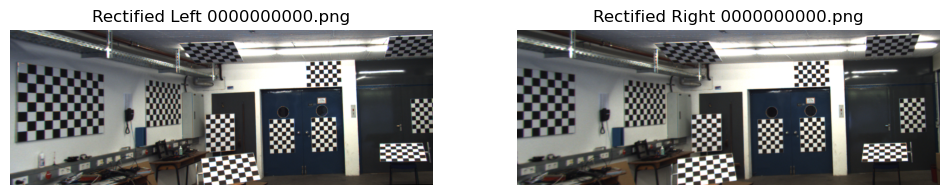

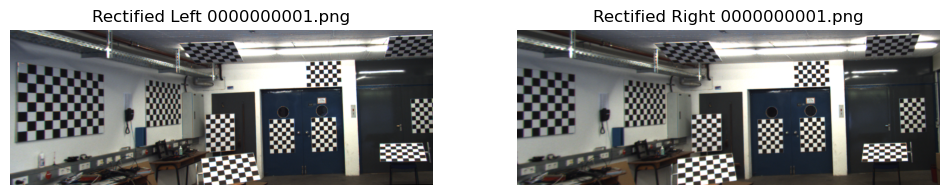

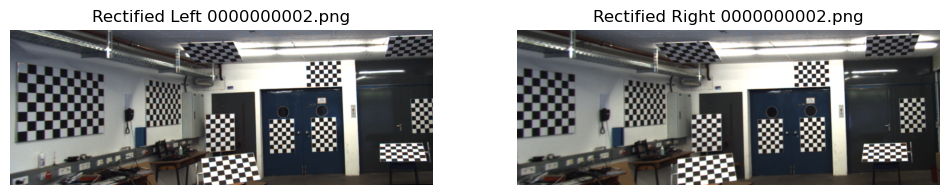

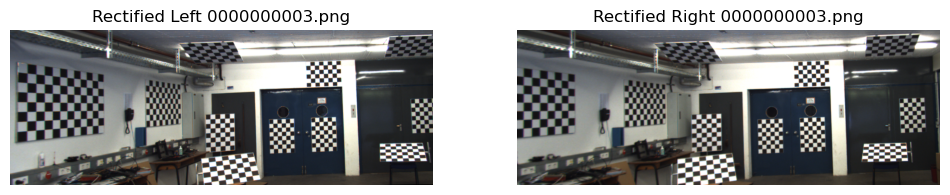

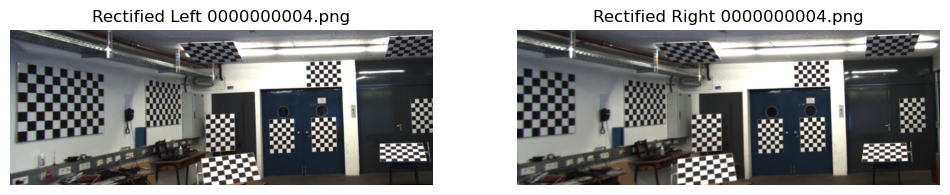

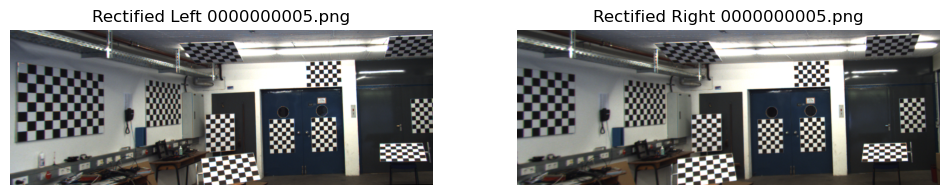

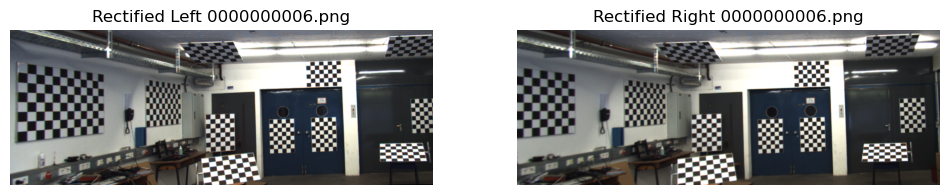

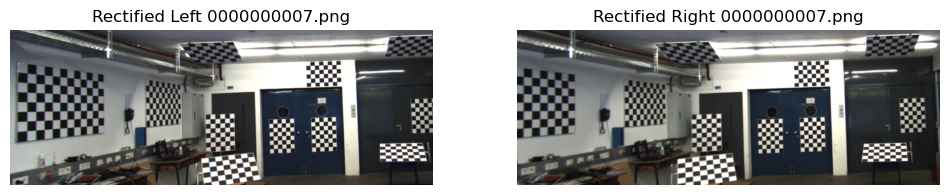

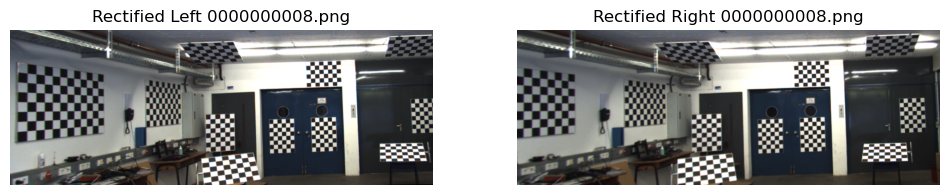

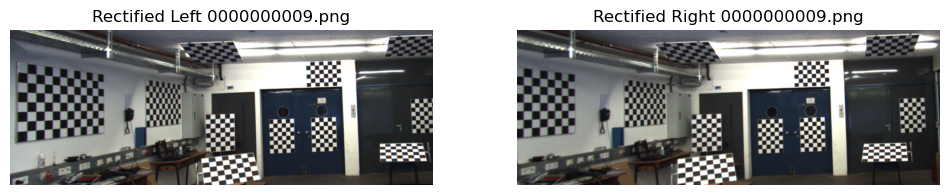

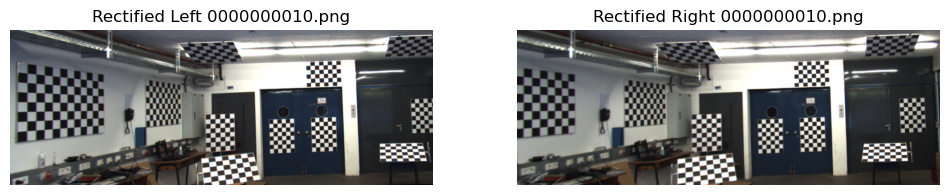

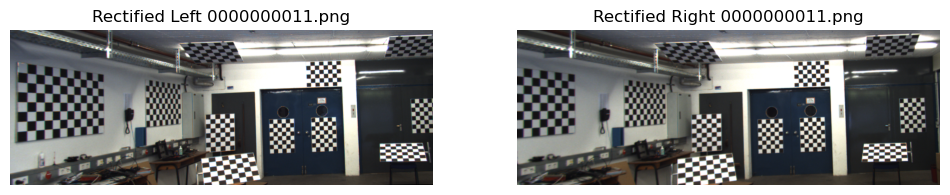

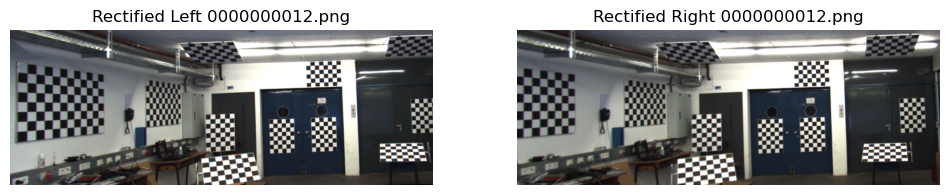

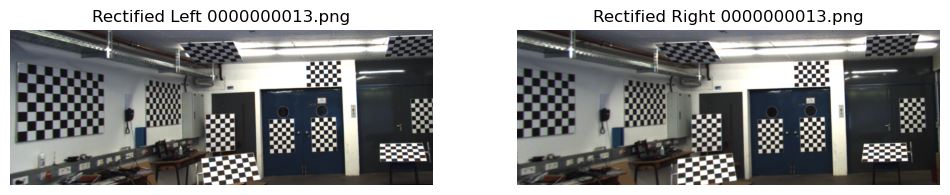

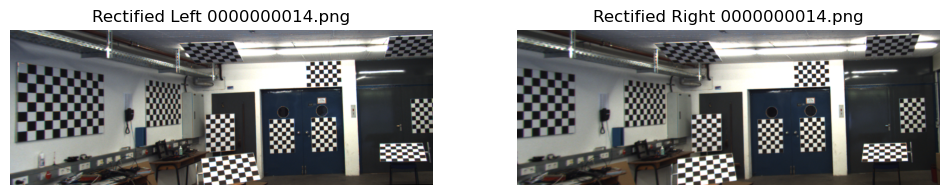

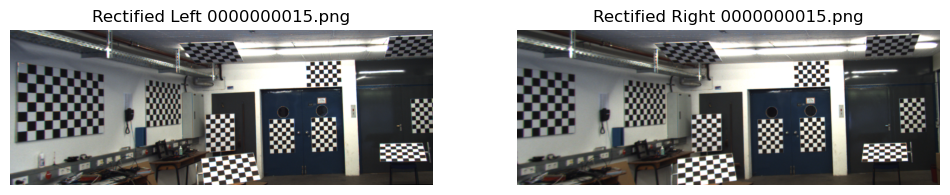

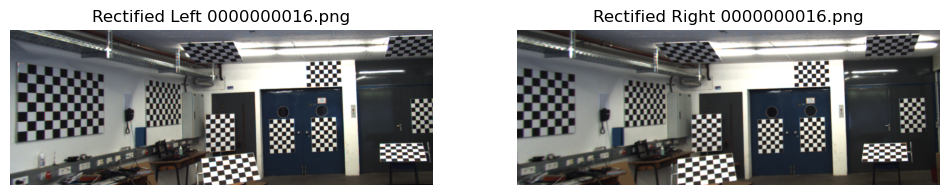

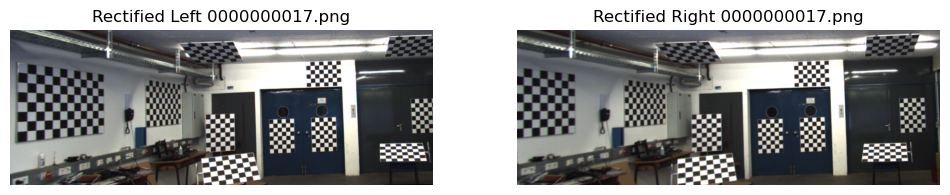

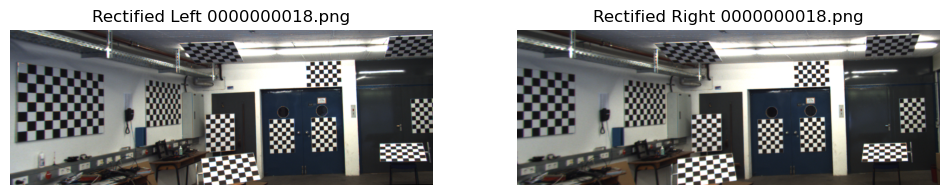

In [17]:
# Define the image size (you can use the size of the first image)
img_size_2 = cv2.imread(cam2[0]).shape[:2][::-1]

# Create the rectification maps
map1x, map1y = cv2.initUndistortRectifyMap(K2_stereo, D2_stereo, R2_rect, P2_rect, img_size_2, cv2.CV_32F)
map2x, map2y = cv2.initUndistortRectifyMap(K3_stereo, D3_stereo, R3_rect, P3_rect, img_size_2, cv2.CV_32F)

# Process all the images
for left_img_path, right_img_path in zip(cam2, cam3):
    # Read the images
    img1 = cv2.imread(left_img_path)  # Left camera image
    img2 = cv2.imread(right_img_path)  # Right camera image

    # Rectify the images
    rectified_img1 = cv2.remap(img1, map1x, map1y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2x, map2y, cv2.INTER_LINEAR)

    # Show the rectified images using matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(rectified_img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Rectified Left {os.path.basename(left_img_path)}")
    axes[0].axis('off')  # Disable the axes

    axes[1].imshow(cv2.cvtColor(rectified_img2, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Rectified Right {os.path.basename(right_img_path)}")
    axes[1].axis('off')  # Disable the axes

    plt.show()
